# Настройки обучения нейронных сетей в `PyTorch`

<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1k5ih-FSbCTuErwBHHi3J3uCN1q4fRzFI) -->

Как правило, обучение моделей в `PyTorch` — это продолжительный процесс, который требует достаточно много усилий. Эти усилия на этапе аналитики сосредотачиваются на подготовке данных и экспериментировании с моделью нейронной сети и ее обучением.

Как будет показано позже, часто среди моделей машинного обучения выбираются готовые модели, которые используются как некоторая основа. Часто эти модели предобучены. Однако качество предобученной модели на целевом наборе данных, как правило, неудовлетворительное. Поэтому модели в любом случае надо доучивать.

Ниже приведен [один из примеров последовательности](https://www.learnpytorch.io/01_pytorch_workflow/#what-were-going-to-cover), которая соответствует общему порядку экспериментов с нейронной сетью.  Текущая практика посвящена вопросу обучения нейронной сети во многих аспектах этого `workflow`.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png" width="900px">

Важно:
* также иметь в виду вопросы ускорения и вычислительной оптимизации обучения нейронных сетей, см., например, [тут](https://habr.com/ru/companies/wunderfund/articles/820721/) и для [`CPU` тут](https://habr.com/ru/companies/ruvds/articles/822711/). 
* И учитывать вопросы логирования результатов экспериментов, см., например, [тут](https://www.learnpytorch.io/07_pytorch_experiment_tracking/).

## Импорт `torch`

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchinfo import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd

Настроим работу с `PyTorch`. Выберем формат работы и устройство для работы.

In [2]:
def torch_stats(): 
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32
    
    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)
        
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)
    
    num_workers=os.cpu_count()
    print ('available number of workers:',num_workers)
    
    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn 

In [3]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 2.2
Using device: cpu
default data type: torch.float32
available number of workers: 8


## Набор данных

Рассмотрим набор данных [`KMNIST`](https://github.com/rois-codh/kmnist), который в этот раз импортируется из пакета `torchvision.datasets`.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
transform_ = lambda x: x.flatten() / 255.0
transform=transforms.Compose([
                           transforms.ToTensor(),
                           transform_,
                            ])

При загрузке набора данных задаются стандартные преобразования `transforms`. Тренировочная часть и тестовая часть загружаются отдельно.

In [6]:
# import ssl

# ssl._create_default_https_context = ssl._create_stdlib_context

In [7]:
train_data = datasets.KMNIST('data', train=True,  download=True,  transform=transform)
test_data  = datasets.KMNIST('data', train=False, download=True, transform=transform)

> Отметим, что набор данных может также быть скаченным вручную
> https://github.com/rois-codh/kmnist


Полученный набор данных представляет собой итерируемый объект. Доступ к отдельным элементам такого датасета может быть получен как для списка. Каждый элемент представляет собой изображение (в нашем случае — вектор) и его метку.

In [8]:
train_data[0][0].shape, train_data[0][1] 

(torch.Size([784]), 8)

In [9]:
name_classes = np.arange(10); 

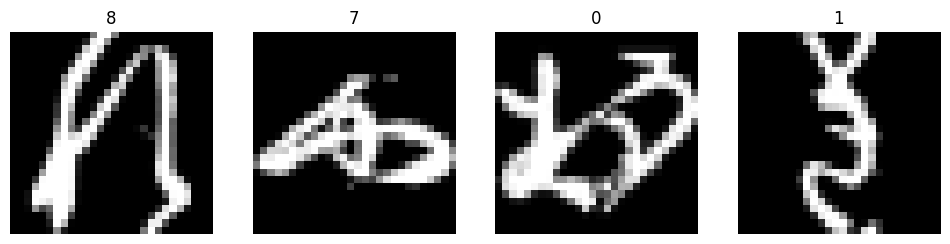

In [10]:
WIDTH = 28
HEIGH = 28
fig, axs = plt.subplots(1,4,figsize=(12,3));
axs[0].imshow(train_data[0][0].view(WIDTH,HEIGH), cmap='gray'); axs[0].set_title(name_classes[train_data[0][1]]); axs[0].axis('off')
axs[1].imshow(train_data[1][0].view(WIDTH,HEIGH), cmap='gray'); axs[1].set_title(name_classes[train_data[1][1]]); axs[1].axis('off')
axs[2].imshow(train_data[2][0].view(WIDTH,HEIGH), cmap='gray'); axs[2].set_title(name_classes[train_data[2][1]]); axs[2].axis('off')
axs[3].imshow(train_data[3][0].view(WIDTH,HEIGH), cmap='gray'); axs[3].set_title(name_classes[train_data[3][1]]); axs[3].axis('off')
plt.show()

Соотвественно можно узнать размер выборок

In [11]:
len(train_data), len(test_data)

(60000, 10000)

После загрузки изображений в формате `pytorch` необходимо автоматизировать генерацию пакетов, по которым будет производиться обучение, то есть батчей. Желательно производить загрузку батчей динамически/стохастически. Другими словами, во время каждой эпохи обучения мы будем вызывать от необходимое количество таких батчей, каждый из которых будет представлять собой заданное количество примеров входных данных, выбранных случайно из последовательности.

Для осуществления указанного кода воспользуемся утилитой `DataLoader` из `torch.utils.data`. Пример реализации показан ниже.

Набор данных MNIST поставляется с обучающим и тестовым набором, но без валидационного набора. Однако, использование валидационного набора кажется крайне желательным, например, чтобы проверить, насколько хорошо модель работает на более или менее независимых данных (по крайней мере, на данных, чьи случайные изменения модель не видит в тренировочной выборке). <br>
Остается понять, почему бы нам просто не использовать тестовые данные? Тестовый набор данных позволяет произвести замер производительности только один раз — после завершения обучения. Тестовый набор покажет действительную обобщающую способность модели. Тестовый набор должен быть максимально независим от тренировочных данных. Валидационный набор данных можно рассматривать как косвенное тестирование модели на данных, похожих на тренировочные. Поэтому часто валидационные данные выбирают из тренировочных. Например, выбирают случайно. <br>
Выбираем валидационный набор данных как 20% от тренировочных. <br>
**Примечание:** валидационный набор всегда должен создаваться из обучающего набора. Никогда не берите валидационный набор из тестового набора. Когда исследователи публикуют научные работы, они должны сравнивать производительность по тестовому набору, и единственный способ обеспечить справедливое сравнение — использовать один и тот же тестовый набор для всех исследователей. Если валидационный набор берется из тестового, то тестовый набор не такой, как у всех, и результаты нельзя сравнивать друг с другом. 
 
Для выделения валидационного набора используем утилиту `random_split` из `torch.utils.data`. 

<blockquote> 
Отметим, что могут быть и другие способы сплита данных.
    
```python
    from torch.utils.data import SubsetRandomSampler
    indices=np.arange(len(train))
    np.random.shuffle(indices)
    
    split=int(np.floor(valid_size*len(train)))
    train_idx = indices[split:]
    valid_idx = indices[:split]
    
    train_sampler=SubsetRandomSampler(train_idx)
    valid_sampler=SubsetRandomSampler(valid_idx)
    
    
    train_loader=torch.utils.data.DataLoader(train_data, batch_size=batch_size,  
                                             sampler=train_sampler, num_workers=num_workers)
    valid_loader=torch.utils.data.DataLoader(train_data, batch_size=batch_size,  
                                             sampler=train_sampler, shuffle=False, num_workers=num_workers)
    test_loader =torch.utils.data.DataLoader(test_data,  batch_size=batch_size, 
                                             shuffle=False,  num_workers=num_workers)

```

</blockquote>

In [12]:
VALID_RATIO = 0.8

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples])

print(f"Training data size : {len(train_data)}, Validation data size : {len(valid_data)}, Test data size : {len(test_data)}")

Training data size : 48000, Validation data size : 12000, Test data size : 10000


Теперь получены три набора данных: валидационный, тренировочный и тестовый. <br>
__Важно__ также отметить, что если тренировочные данные используются с аугментацией, то валидационный набор данных лучше использовать без аугментации. Ниже показан пример того как это можно сделать.

```python
    valid_data = copy.deepcopy(valid_data)
    valid_data.dataset.transform = test_transforms
```




Теперь создадим загрузчики данных. 

>Важно отметить, что загрузка набора данных и загрузчик данных является одтдельными по важности составляющими обучени нейронных сетей.

In [13]:
BATCH_SIZE = 64

train_loader = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

val_loader = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_loader = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

 
print(f"Training data batches : {len(train_loader)}, Validation data batches : {len(val_loader)}, Test data batches : {len(test_loader)}")

Training data batches : 750, Validation data batches : 188, Test data batches : 157


Проверим размер каждого батча.

In [14]:
images, _ =  next(iter(train_loader))
images.shape

torch.Size([64, 784])

Проведем визуализацию батча. Для этого в `torchvision` предусмотрена специальная функция `make_grid`.
<!-- 
Обратите внимание на порядок операций в примере с визуализацией. Сначала производится преобразование размеров батча. Из размеров $[64, 784]$, означающих $64$ вектора, каждый по $784$ значения, мы получаем 64 изображения, каждое размером $28\times 28$.\
Однако также мы добавляем дополнительную пустую размерность. То есть вместо того, чтобы получить массив $[64, 28, 28]$, мы получаем размер $[64, 1, 28, 28]$. Дополнительная размерность означает канал изображения. В нашем случае канал только $1$. Однако в более продвинутых задачах анализа изображений мы будем использовать и по $3$ канала.\
Аналогично, и в нашем случае для визуализации батч будет создан с $3$ каналами. Поскольку мы формируем изображение, где по горизонтали должно уместиться 8 изображений, то размер будет $[3, 28\cdot 8, 28\cdot 8] = [3, 224, 224]$.

Также важно отметить, что после получения батча мы проводим операцию `transpose((1, 2, 0))` — то есть каналы становятся `3`-й размерностью, а не `1`-й. Тут имеет место крайне важное различие между представлением данных в `matplotlib` и `torch`. В `matplotlib` каналы — это последняя размерность. Тогда как в `torch` каналы — это или `1`-я размерность, или `2`-я, если речь идет о наборе изображений (батче). -->

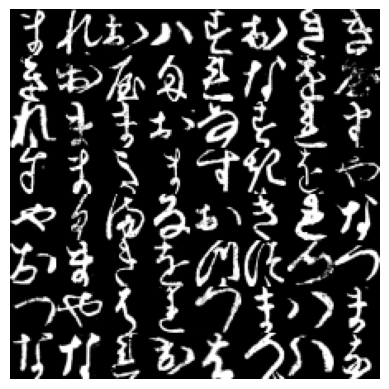

(torch.Size([64, 1, 28, 28]), torch.Size([3, 224, 224]), (224, 224, 3))

In [15]:
images = images.reshape(-1,1,28,28)
batch = torchvision.utils.make_grid(images, nrow = int(np.sqrt(images.shape[0])), padding = 0)
vis_batch = batch.data.numpy().transpose((1, 2, 0))*255
plt.imshow(vis_batch); 
plt.axis('off');
plt.show()
images.shape, batch.shape,  vis_batch.shape


# Обучение полносвязной архитекутры

In [16]:
IMAGE_WIDTH = 28 
IMAGE_HEIGH = 28

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(IMAGE_WIDTH*IMAGE_HEIGH, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x  #log(softmax(x)) in loss assumed

Также важно уточнить, что в указанных структурах могут быть заданы не только полные модели, но и их [отдельные слои](https://github.com/Devinterview-io/pytorch-interview-questions?tab=readme-ov-file#process-for-implementing-custom-layers).

Проверим результат.

In [17]:
model = Model()

summary(model,input_size =(1,784))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 10]                   --
├─Linear: 1-1                            [1, 64]                   50,240
├─Linear: 1-2                            [1, 64]                   4,160
├─Linear: 1-3                            [1, 10]                   650
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.06
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.22
Estimated Total Size (MB): 0.22

Как и прежде, используем алгоритм `Adam` с параметрами по умолчанию для обновления нашей модели. Улучшенные результаты можно получить, перебирая различные оптимизаторы и скорости обучения, однако стандартный `Adam` обычно является хорошей отправной точкой. 

In [18]:
optimizer = optim.Adam(model.parameters())

Аналогично предыдущим занятиям зададимся функцией потерь `CrossEntropyLoss`.

In [19]:
criterion = nn.CrossEntropyLoss() #This criterion assume built-in `log_softmax` 

Отметим, что на самом деле, если используется `GPU` в качестве вычислителя, то следует отправить и функцию потерь и модель на устройство.

In [20]:
model = model.to(device)
criterion = criterion.to(device)

> Если для обучения моделей используют несколько GPU, то самым простым подходом в этой ситуации будет применение класса `DistributedDataParallel` (`DDP`). В результате будут созданы несколько идентичных процессов, а градиенты будут агрегироваться на шаге обратного прохода. <br>
> Также [может быть использован](https://habr.com/ru/companies/wunderfund/articles/820721/) `Fully Sharded Data Parallel` (`FSDP`, параллелизм с полным шардингом данных). В этом режиме данные асинхронно распределяются между `GPU` вместо того чтобы запускать код на каждом `GPU` с одинаковыми моделями и с одинаковыми состояниями оптимизатора.
> `from torch.distributed.fsdp import FullyShardedDataParallel as FSDP` и `model = FSDP(model)`

>Для более подробного исследования производительности модели рекомендуется использование профайлера https://pytorch.org/blog/introducing-pytorch-profiler-the-new-and-improved-performance-tool/.

Также напомним, что в версии `PyTorch 2.x` доступен способ ускорения модели при помощи ее компиляции [`torch.compile`](https://pytorch.org/docs/stable/generated/torch.compile.html). [В этом режиме](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html) вычислительный граф модели собирается при первом проходе по ней вместо того, чтобы вычисляться динамический каждый раз.

Отметим, что на сегодня `torch.compile` работает не на всех платформах.

In [21]:
from sys import platform
if platform == "linux" or platform == "linux2":
    model = torch.compile(model)

Также создадим отдельную функцию для расчета точности модели.

In [22]:
def calculate_accuracy(y_pred, y):
    with torch.no_grad():
        top_pred = y_pred.argmax(1, keepdim=True)
        correct = top_pred.eq(y.view_as(top_pred)).sum()
        acc = correct.float() / y.shape[0]
    return acc

metric = calculate_accuracy

Перед началом тренировки запишем функцию `train`, которая должна реализовывать тренировку в рамках 1 эпохи. 

Функция будет выбирать все батчи из dataloader в формате `x` — данные и `y` — ответы. Затем для каждого батча будет производится расчет выхода модели `model.forward(x)` и расчет параметров `loss` (потери) и `acc` (точность). 

Функция имеет следующую последовательность действий:
- перевод модели в режим обучения (`model.train()`).
- перебор загрузчика данных, возвращая `batch`.
- размещение д"анных на `GPU`, если есть.
- очистка градиента `zero_grad(set_to_none = True)`.
- передача пакета изображений `x` в модель, чтобы получить предсказания `y_pred`.
- вычисление функции потерь между предсказаниями и фактическими метками.
- вычисление точности между предсказаниями и реальными метками.
- вычисление градиента каждого параметра.
- обновление параметров, выполнив шаг оптимизатора.
- обновление метрики.

*Отметим* 
* В режиме тренировки модель должна иметь директиву train `model.train()`, которая необходима в ряде элементов (например, batchnorm), имеющих разное поведение при тренировке и эксплуатации.

* Также отметим, что `dataloader` вызывается при помощи `tqdm` — то есть т. н. *progress bar*.

In [23]:
def train(model, dataloader, optimizer, criterion, metric,  device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none = True)

        y_pred = model(x)

        loss = criterion(y_pred, y)
        acc  = metric(y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

Аналогично создадим функцию `evaluate`, которая позволяет оценивать работу модели, например, для валидационного или тестового наборов данных. Особенностями этой функции будут директива `model.eval()` и `torch.inference_mode()`, которые необходимы в режиме тестирования нейронной сети.
<!-- 
`torch.no_grad()` гарантирует, что градиенты не будут вычисляться для всего, что находится внутри блока `with`. Поскольку нашей модели не придется вычислять градиенты, она будет работать быстрее и использовать меньше памяти.  -->

In [24]:
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.inference_mode():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x, y = x.to(device), y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

Запишем вспомогательную функцию расчета времени.

In [25]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Итоговый процесс обучения будет состоять из процедур тренировки и оценки для каждой эпохи. Также будет оцениваться время работы каждой эпохи.

В процедуру включена проверка модели на лучшее значение метрики на валидации. Лучшая метрика сохраняется. Точнее, сохраняются ее параметры `model.state_dict()`.

In [26]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
    f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')


  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 1.737 | Train Acc: 40.16%  | Val. Loss: 1.218 | Val. Acc: 63.57%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 1.013 | Train Acc: 68.96%  | Val. Loss: 0.916 | Val. Acc: 72.30%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 0.863 | Train Acc: 73.56%  | Val. Loss: 0.836 | Val. Acc: 74.50%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.799 | Train Acc: 75.64%  | Val. Loss: 0.785 | Val. Acc: 75.98%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 0.745 | Train Acc: 77.50%  | Val. Loss: 0.737 | Val. Acc: 77.65%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.698 | Train Acc: 78.95%  | Val. Loss: 0.694 | Val. Acc: 78.78%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 4s
	Train Loss: 0.657 | Train Acc: 80.21%  | Val. Loss: 0.664 | Val. Acc: 79.80%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 4s
	Train Loss: 0.624 | Train Acc: 81.11%  | Val. Loss: 0.636 | Val. Acc: 80.30%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 4s
	Train Loss: 0.595 | Train Acc: 81.96%  | Val. Loss: 0.609 | Val. Acc: 81.22%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 3s
	Train Loss: 0.569 | Train Acc: 82.75%  | Val. Loss: 0.581 | Val. Acc: 82.21%


Теперь вместо того, чтобы останавливаться на последней эпохе, выберем лучшую эпоху и загрузим ее значения. 

Проверим точность модели на тестовых данных.

In [27]:
model.load_state_dict(torch.load('best_model.pt'))

test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 1.007 | Test Acc: 68.16%


Отметим, что в общем случае есть несколько опций [сохранения моделей](https://pytorch.org/tutorials/beginner/saving_loading_models.html). 
* Сохранение всей модели с помощью функции `torch.save()` и передача всей модели.
* Сохранение только обучаемых параметров и весов модели путем сохранения `state_dict` модели. `State_dict` — это объект словаря `Python`, который содержит обучаемые параметры модели (например, веса и смещения) и другую информацию, необходимую для восстановления архитектуры и параметров модели.

Зачастую `state_dict` имеет меньший размер файла, и это делает загрузку модели более интуитивной, так как не требует явной загрузки архитектуры модели. Модель загружается отдельно. Однако, сохранение всей модели позволяет сохранить весь объект, включая архитектуру модели, параметры и любую другую связанную информацию (например, состояние оптимизатора). При этом все состояние модели сохраняется как единый объект в файл формата `pickle`.

Ниже приведен пример сохранения полной модели.

In [28]:
torch.save(model, 'file_path.p')

In [29]:
model = torch.load('file_path.p')
model.eval()

Model(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

Сохраненные модели можно запускать в других форматах, например, в релиз можно запускать модели в более быстром [формате](https://pytorch.org/docs/stable/jit.html)  [`TorchScript`](https://pytorch.org/tutorials/beginner/Intro_to_TorchScript_tutorial.html) (формат использует  [`C++` компилятор](https://pytorch.org/tutorials/advanced/cpp_export.html)).

In [30]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save
model = torch.jit.load('model_scripted.pt')
model.eval()

RecursiveScriptModule(
  original_name=Model
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (fc3): RecursiveScriptModule(original_name=Linear)
)

[Также возможно сохранение всего чекпоинта](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training) при обучении модели (не только состояния модели, но и параметров обучения, например)

```python
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            ...
            }, PATH)
```

## Задание

__1.__ Предлагается дополнить процедуру обучения сохранением истории изменения метрики и лосса на трейне и валидации в виде скользящего среднего и СКО.

__2.__ Выбор размера батча `batch_size` — важный элемент в обучении любой модели. Это связано с несколькими вещами. 
* Во-первых, чем больше батч, тем в среднем лучше обобщающая способность модели. Однако, чем меньше батч, тем выше точность на тренировочных данных (без учета обобщающей способности и вопроса переобучения). 
* Во-вторых, [правильный выбор размера батча](https://habr.com/ru/companies/wunderfund/articles/816657/) позволяет достигать оптимальной производительности модели на этапе обучения (да и работы) модели. Это связано с т. н. эффектом латентности — временем загрузки данных на вычислитель. А также это связано с объемом памяти вычислителя. 
* В-третьих, чем больше размер батча, тем менее жесткие требования к выбору гиперпараметров модели и тем больше в целом может быть выбрана скорость обучения (то есть обучение будет быстрее, усреднение разброса параметров по батчам будет меньше). 

Поэтому в ряде случаев рекомендуется проводить процедуру обратного распространения ошибки не по одному батчу, а по нескольким. То есть копить градиент `forward propagation` нескольких батчей, прежде чем запустить (один раз) `backward propagation`. Таким образом создается эффект «виртуально» большей памяти вычислителя (напр., `GPU`). 

__Предлагается__ реализовать подход «виртуальный батч» самостоятельно.


__3.__ Предлагается дополнить процесс обучения процедурой `early stop` по 3-м эпохам обучения и условию что метрика на валидации не меняется более чем на $5\%$ по скользящему среднему.

__4.__ Предлагается создать функции или класс для тренировоки модели и сохранения ее результатов. Пример неполной реализации можно найти, например, [тут](https://habr.com/ru/articles/553716/) и [тут](https://flower.ai/docs/framework/tutorial-quickstart-pytorch.html), а также [тут](https://neptune.ai/blog/pytorch-loss-functions).

<code style="color : red">__5.*__</code> Иногда для удобства конфигурирования экспериментов типичные гиперпараметры создаются через класс конфигурации, как это показано ниже.

In [31]:
import os
from dataclasses import dataclass
from typing import Tuple

@dataclass
class Config:

    data_dir: str = os.environ.get("PATH_DATASETS", ".")
    save_dir: str = "logs/"
    batch_size: int = 256 if torch.cuda.is_available() else 64
    max_epochs: int = 10
    device: str = device,    
    devices: int = 1

config = Config()
print(config.device[0], config.batch_size )

cpu 64


__Предлагается__ реализовать такую настройку для своих экспериментов самостоятельно.

<code style="color : red">__6.*__</code> Предлагается дополнить процедуру обучения более единообразным логированием результатов. Например при помощи словаря. Пример словаря показан ниже.
```python
        results = {"train_loss": [],
                   "train_acc":  [],
                   "test_loss":  [],
                   "test_acc":   []}
```

```python
        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
```

<code style="color : red">__7.*__</code> Использование сохранений `state_dict` позволяет запускать обучение новых моделей в режиме `warm start` — то есть с начальными значениями параметров, проинициализированными результатами предыдущего обучения. Так новой модели будет легче обучиться. Например, это будет актуальным, если вы обучили модель, запустили ее в релиз, затем собрали новые данные и готовы заново обучить модель. Или если вы взяли готовую модель из стандартных библиотек (предобученную модель). Тогда `warm start` упростит процесс обучения и позволит добиться большей точности, особенно в случае небольшого тренировочного набора данных. 

Позже эта тема будет рассмотрена более подробно. 

Тут __предлагается__ обучающемуся создать новую модель, например, имеющую на один слой больше предыдущей модели, загрузить в нее предобученные весовые параметры и запустить новый процесс обучения, например, поменяв оптимизатор. Таким образом мы как бы симулируем новизну эксперимента. 

> Новый слой должен иметь новое название, не совпадающее с объявленными ранее слоями.

> Независимо от того, загружаете ли вы параметры из частичного `state_dict`, в котором отсутствуют некоторые ключи, или загружаете `state_dict` с большим количеством ключей, чем в модели, в которую вы загружаете параметры, вы можете установить аргумент `strict` в значение `False` в функции `load_state_dict()`, чтобы игнорировать несовпадающие ключи.

> Если вы хотите загрузить параметры из одного слоя в другой, но некоторые ключи не совпадают, просто измените имена ключей параметров в загружаемом `state_dict`, чтобы они совпадали с ключами в модели, в которую вы загружаете.

# Различные способы отслеживания экспериментов по машинному обучению 

В рассмотренных примерах отслеживание хода обучения модели проводилось с помощью имеющихся инструментов `Python` (это были списки, в более продвинутых экспериментах полезно бы было использование словарей, `Pandas DataFrames` или логирование результатов, например, в `csv` файлы). Однако, если экспериментов становится слишком много, то такой подход может помешать точному логированию результатов. Поэтому в проектах, требующих достаточного большого числа испытаний, используются специализированные инструменты.  

Существует ряд утилит для отслеживания экспериментов по машинному обучению. В таблице описаны некоторые из них. Более подробный анализ можно найти, например, [тут](https://neptune.ai/blog/best-ml-experiment-tracking-tools#tools?utm_source=medium&utm_medium=crosspost&utm_campaign=blog-best-ml-experiment-tracking-tools).

| **Метод** | **Установка** | **Плюсы** | **Контакты** | **Стоимость** |
| ----- | ----- | ----- | ----- | ----- |
| Словари, списки Python, CSV-файлы, Pandas DataFrames | Нет | Легко настраивается, работает на чистом Python | Трудно отслеживать большое количество экспериментов | Бесплатно |
| [TensorBoard](https://www.tensorflow.org/tensorboard/get_started) | Минимально, установите [`tensorboard`](https://pypi.org/project/tensorboard/) | Расширения, встроенные в PyTorch, широко известны и используются, легко масштабируются. | Пользовательский опыт не так приятен, как у других вариантов. | Бесплатно |
| [Weights & Biases Experiment Tracking](https://wandb.ai/site/experiment-tracking) | Минимально, установите [`wandb`](https://docs.wandb.ai/quickstart), заведите аккаунт | Невероятный пользовательский опыт, делает эксперименты публичными, отслеживает практически все. | Требуется внешний ресурс за пределами PyTorch. | Бесплатно для личного использования | 
| [MLFlow](https://mlflow.org/) | Минимально, установите `mlflow` и начинайте отслеживать | Полностью открытое управление жизненным циклом MLOps, много интеграций. | Немного сложнее настроить удаленный сервер отслеживания, чем в других сервисах. | Бесплатно | 

<!-- <img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/07-different-places-to-track-experiments.png" alt="различные места для отслеживания экспериментов по машинному обучению" width=900/> -->

Рассмотрим утилиту [`TensorBoard`](https://www.tensorflow.org/tensorboard/get_started). Утилита `TensorBoard` является частью библиотеки глубокого обучения `TensorFlow` и представляет собой отличный способ визуализации различных частей вашей модели.


Для работы с `TensorBoard` в `PyTorch` можно использовать класс [`torch.utils.tensorboard.SummaryWriter()`](https://pytorch.org/docs/stable/tensorboard.html). Объект позволяет сохранять различные части прогресса обучения модели в файл.

Перед работой с `SummaryWriter()` необходимо установить `TensorBoard`. Установка может быть произведена при помощи команды ```pip install tensorboard```.

> __Отметим__, что помимо встроенного в `PyTorch` `tensorboard` сегодня есть проект [`TensorboardX`](https://github.com/lanpa/tensorboardX), значительно расширяющий его возможности при сохранении синтаксиса.

По умолчанию класс `SummaryWriter()` сохраняет различную информацию о модели в файл, заданный параметром `log_dir`. 
По умолчанию `log_dir` находится в папке `runs/CURRENT_DATETIME_HOSTNAME`, где `HOSTNAME` — это имя компьютера. Имя файла можно настроить по своему усмотрению.

Результаты работы `SummaryWriter()` сохраняются в формате [`TensorBoard`](https://www.tensorflow.org/tensorboard/).


Также для того, чтобы запустить `TensorBoard` в jupyter notebook, необходимо указать директиву `%load_ext tensorboard`.

> В дополнении можно найти например этих урокиhttps://github.com/HyoungsungKim/Pytorch-tensorboard_tutorial

In [32]:
# !pip install tensorboard

In [33]:
%load_ext tensorboard
%reload_ext tensorboard

In [91]:
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 1921), started 0:02:47 ago. (Use '!kill 1921' to kill it.)

Создадим объект `writer` класса `SummaryWriter` c указанием пути записи логов в `log_dir`.

In [116]:
from torch.utils.tensorboard import SummaryWriter
from tensorboardX import SummaryWriter
from datetime import datetime
import os

date = datetime.today().strftime('%Y-%m-%d')
path_logs = "run_"+date
writer = SummaryWriter(log_dir=path_logs)
print(path_logs)

run_2024-07-05


В наиболее простом случае среди всего функционала `SummaryWriter` потребуется метод `add_scalar`.

Метод можно использовать для записи напрямую скалярных значений или использовать структуру `tag_scalar_dict`, которая позволяет выдавать словарь за скаляр.

В первом случае для наших реализй метод должен быть вызван для 4 переменных обучения с указанием метки, например `"Metric/valid"`, необходимого значения и номера эпохи обучения.
```python
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/valid", valid_loss, epoch)
    writer.add_scalar("Metric/train", train_acc, epoch)
    writer.add_scalar("Metric/valid", valid_acc, epoch) 
        
```

Однако, мы воспользуемся структурой `tag_scalar_dict`. Так можно будет более удобно заводить и анализировать результаты для экспериментов. 


После проведения экспериментов желательно указывать `writer.flush()` для выгрузки результатов в `tensorboard`. Если объект больше не понадобиться, то можно также указать `writer.close()`.

In [117]:
LR = 0.01

model = Model()
model = model.to(device)
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)

 

In [118]:
EPOCHS = 2

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric,device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | LR {optimizer.param_groups[0]["lr"] :.4f}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
    f'| Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')
 

    writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": torch.tensor(train_loss),
                                            "val_loss":  torch.tensor(valid_loss)},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
    writer.add_scalars(main_tag="Metric/Accuracy", 
                           tag_scalar_dict={"train_acc": torch.tensor(train_acc),
                                            "val_acc":   torch.tensor(valid_acc)}, 
                           global_step=epoch)

        # Track the PyTorch model architecture
writer.add_graph(model=model, 
                     input_to_model=torch.randn(BATCH_SIZE,  28 * 28).to(device))
    
writer.flush()
# Close the writer
#     writer.close()

  0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 4s | LR 0.0100
	Train Loss: 0.933 | Train Acc: 69.72% | Val. Loss: 0.608 | Val. Acc: 81.45%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 3s | LR 0.0100
	Train Loss: 0.521 | Train Acc: 83.88% | Val. Loss: 0.472 | Val. Acc: 85.83%


Полезно также будет записать гиперпараметры обучения и полученные при этом значения точности на тестовой выборке. Ниже приведен пример реализации этого кода.

In [119]:
model.load_state_dict(torch.load('best_model.pt'))

test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.853 | Test Acc: 73.19%


In [120]:
writer.add_hparams({'lr': LR, 'bsize': BATCH_SIZE},
                   {'hparam/test_accuracy': test_loss, 
                    'hparam/test_loss': test_acc})
writer.flush()

Также выгрузим в `tensorboard` архитектуру самой модели.

In [121]:
x, y = next(iter(test_loader))
writer.add_graph(model, x)
writer.flush()

Также можно выгружать и примеры изображений. Например, так, как это показано ниже.

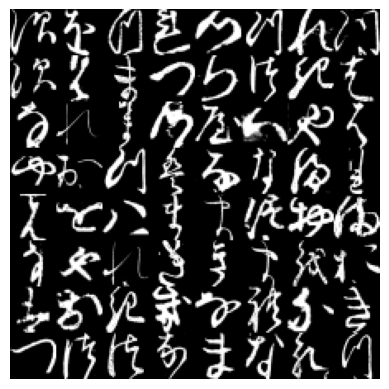

torch.Size([64, 1, 28, 28]) torch.Size([3, 224, 224]) (224, 224, 3)


In [122]:
images = x.reshape(-1,1,28,28)
batch = torchvision.utils.make_grid(images, nrow = int(np.sqrt(images.shape[0])), padding = 0)
vis_batch = batch.data.numpy().transpose((1, 2, 0))*255
plt.imshow(vis_batch); 
plt.axis('off');
plt.show()
print(images.shape, batch.shape,  vis_batch.shape)


writer.add_image('test_images', batch*255)
writer.flush()

Сессия больше не понадобится, поэтому закроем ее.

In [127]:
writer.close()

Сервер `tensorboard` можно запускать для анализа моделей по-разному. В рамках `jupyter` для анализа моделей есть утилита `tensorboard.notebook`.

> Отметим, что можно запустить сессию из командной строки `tensorboard --logdir {PATH}`. Как правило, сессия будет на одном из localhost, например `http://localhost:6006/`. Порт можно задавать вручную. Также для запуска сессий можно воспользоваться сервисом [`tensorboard.dev`](https://tensorboard.dev/).
> Также можно запустить сервис при помощи магических команд:
```python
    %load_ext tensorboard # line magic to load TensorBoard
    %tensorboard --logdir runs # run TensorBoard session with the "runs/" directory
```

In [128]:
from tensorboard import notebook

notebook.list() # View open TensorBoard instances

Known TensorBoard instances:
  - port 6006: logdir runs (started 0:15:58 ago; pid 1921)
  - port 6007: logdir run_2024_07_05 (started 0:03:23 ago; pid 2007)


В рамках утилиты можно запустить сессию так, как показано ниже.

In [129]:
notebook.display(port=6007, height=500)

Selecting TensorBoard with logdir run_2024_07_05 (started 0:03:24 ago; port 6007, pid 2007).


In [130]:
%tensorboard --logdir run_2024_07_05

Reusing TensorBoard on port 6007 (pid 2007), started 0:03:25 ago. (Use '!kill 2007' to kill it.)

## Задание

__1.__ На самом деле, поскольку каждый эксперимент должен записываться отдельно. Создадим функцию, автоматически создающую нужный `writer`.

Функция будет создавать `log_dir` вида `runs/timestamp/experiment_name/model_name/extra`,
где `timestamp` — дата, `experiment_name` — имя эксперимента, `model_name` — имя модели, `extra` — дополнительная информация. 

Функция возвращает объект типа `SummaryWriter` и путь к нужной директории.

In [65]:
from datetime import datetime
import os

def create_writer(experiment_name, model_name,  extra, exp_dir = "exp_"):

    timestamp = datetime.now().strftime("%d-%m-%Y") # returns current date in YYYY-MM-DD format
 
    log_dir = os.path.join(exp_dir, timestamp, experiment_name, model_name)
    
    if extra:
        log_dir = os.path.join(log_dir, extra)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir), log_dir

In [66]:
example_writer = create_writer(experiment_name="FashionMNIST",
                               model_name="test",
                               extra="15_epochs")

[INFO] Created SummaryWriter, saving to: exp_/05-07-2024/FashionMNIST/test/15_epochs...


__Предлагается__ организовать серию из нескольких экспериментов так, чтобы записать их результаты интерпретируемым и восстанавливаемым способом. Желательно к каждому эксперименту в нужную директорию сохранять весовые параметры модели, настройки гиперпараметров и примеры результатов работы модели на валидационном или тестовом наборах данных. 

<code style="color : red">__2.*__</code> Для более продвинутой работы с отслеживанием экспериментов рекомендуется использование [`MLFlow`](https://madewithml.com/#course).

# Библиотеки на основе `PyTorch`

В ходе прохождения практик можно заметить, что почти всегда ряд операций повторяется. К таким операциям относится, например, инициализация модели, задание эпохи (шага) тренировки и валидации, сами процедуры тренировки и оценивания модели. При этом такие процедуры требуют достаточно много кода, в котором можно допустить ошибки. Поэтому возникает желание иметь типичные процедуры заданными заранее. Одним из способов реализации этого подхода для `PyTorch` являются такие фреймворки, как [`PyTorch Ligthing`](https://lightning.ai/), [`Ignite`](https://pytorch-ignite.ai/), [`Fast AI`](https://www.fast.ai/) и другие. [Результаты сравнения](https://neptune.ai/blog/pytorch-lightning-vs-ignite-differences) этих фреймворков могут зависеть от задачи. На сегодня [`PyTorch Ligthing`](https://github.com/Lightning-AI/pytorch-lightning/tree/master) наиболее популярный.

Идея `PyTorch Ligthing` заключается в [упрощении типичных процедур `PyTorch`](https://pypi.org/project/pytorch-lightning/) [без излишнего создания абстракций над ними](https://adityassrana.github.io/blog/programming/pytorch/2020/09/25/Modern-PyTorch.html#Lightning). Иллюстрация этого принципа приведена ниже.

<img src="https://adityassrana.github.io/blog/images/copied_from_nb/images/fast_2.gif">

Отметим, что [`PyTorch Ligthing`](https://github.com/Lightning-AI/pytorch-lightning/tree/master) сегодня имеет свою экосистему, в которую, например:
* модуль [`Torchmetrics`](https://lightning.ai/docs/torchmetrics/stable/) — для удобного управления метриками обучения;
* модуль [`Lightning Fabric`](https://github.com/Lightning-AI/pytorch-lightning?tab=readme-ov-file#lightning-fabric-expert-control) — для оптимизации работы с большими моделями на больших вычислительных мощностях.

Типичная структура объекта `pl` ([`PyTorch Ligthing`](https://github.com/Lightning-AI/pytorch-lightning/tree/master)) описывает не только саму модель, но этапы ее обучения, пример показан ниже:

```python
    class Model(pl.LightningModule):

        def __init__(self):
            ...

        def forward(self, x):
            ...

        def training_step(self, batch, batch_idx):
            ...

        def configure_optimizers(self):
            ...
```

При этом удобство состоит в возможности логирования результатов и структуре запуска обучения модели в виде
```python

    trainer = pl.Trainer(gpus=0, max_epochs=3, progress_bar_refresh_rate=20)
    trainer.fit(model, train_loader)
```
или, например, запуск обучения на нескольких `GPU` с пониженной точностью `FP16`.
```python
    trainer = pl.Trainer(gpus=4, plugins='deepspeed', precision=16)
```

Также `PyTorch Ligthing` поддерживает логирование через CSV-файл и [стандартные логеры](https://lightning.ai/docs/pytorch/stable/extensions/logging.html#supported-loggers), например `TensorBoard`.
```python
    from lightning.pytorch.loggers import TensorBoardLogger
```
Ниже показан пример работы, больше примеров смотрите в [официальном репозитории](https://github.com/Lightning-AI/tutorials/tree/main/lightning_examples).

In [ ]:
# !pip install pytorch-lightning
# !pip install torchmetrics

In [67]:
import pytorch_lightning as pl
from lightning.pytorch.loggers import TensorBoardLogger
from torchmetrics.classification import  Accuracy

In [68]:
class ModelPL(pl.LightningModule):
    def __init__(self, lr=0.01):
        super().__init__()
        
        self.lr = lr
        self.model = Model()
        self.criterion = nn.CrossEntropyLoss()
        
        self.train_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy   = Accuracy(task="multiclass", num_classes=10)
        self.test_accuracy  = Accuracy(task="multiclass", num_classes=10)
        
        self.save_hyperparameters()
    
    def forward(self, x):
        x = self.model(x)
        return x                           
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        return loss

    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters(), lr = self.lr)
        return opt

In [69]:
model = ModelPL()

Отметим, что вместо логера можно задать ```enable_checkpointing=False, logger=False```. Однако мы создадим `CSVLogger` c сохранением результатов в `CSV` файл в заданной директории.


In [70]:
from lightning.pytorch.loggers import CSVLogger

In [71]:
trainer = pl.Trainer(
    max_epochs=10,
    logger=CSVLogger(save_dir="D://test"),
)

trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders = val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params
------------------------------------------------------
0 | model          | Model              | 55.1 K
1 | criterion      | CrossEntropyLoss   | 0     
2 | train_accuracy | MulticlassAccuracy | 0     
3 | val_accuracy   | MulticlassAccuracy | 0     
4 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [72]:
test_acc = trainer.test(model, dataloaders=test_loader, )
print(test_acc)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8306000232696533     │
│         test_loss         │    0.6171103715896606     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6171103715896606, 'test_acc': 0.8306000232696533}]


Покажем также возможность сохранения, загрузки модели и [использования модели в режиме предсказания](https://pytorch-lightning.readthedocs.io/en/1.6.5/common/production_inference.html).

<blockquote>
    
Отметим также возможность задания режима работы в структуре `pl.LightningModule`
```python
    def predict_step(self, batch, batch_idx):
        return self(batch)
```    

In [73]:
trainer.save_checkpoint("best_model.ckpt", weights_only=True)

model = ModelPL.load_from_checkpoint("best_model.ckpt")
model

ModelPL(
  (model): Model(
    (fc1): Linear(in_features=784, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=10, bias=True)
  )
  (criterion): CrossEntropyLoss()
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
)

In [74]:
model.eval()
x,y = next(iter(test_loader))

with torch.inference_mode():
    y_hat = model(x)

In [75]:
predicts = torch.argmax(y_hat[:5], dim=1)
predicts,y[:5]

(tensor([5, 9, 3, 8, 3]), tensor([2, 9, 3, 8, 3]))

## Задание

__1.__ Переработайте модель `ModelPL` добавив оптимизатор `SGD` подобрав при этом его параметры.

> Желательно провести настройку при помощи фреймворков типа [`optuna`](https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py) или [`ray`](https://docs.ray.io/en/latest/tune/examples/tune-pytorch-cifar.html) вместо простого перебора по сетке (`GridSearch`).

__2.__ Изучите содержание директории логирования самостоятельно.

<code style="color : red">__3.*__</code> __Предлагается__ дополнительно изучить возможности оптимизации тренировки при помощи функционала `Fabric`, например как показано тут https://github.com/Lightning-AI/pytorch-lightning?tab=readme-ov-file#lightning-fabric-expert-control

<code style="color : red">__4.*__</code> Часто в `Pytorch Lighting` для загрузки данных описывается отдельный класс загрузки данных. [Пример](https://github.com/ivan-chai/isscai-cv-2024/blob/master/01-pytorch-classification/01-pytorch-basics.ipynb) описани ятакого класса для набора данных CIFAR10 можно найти ниже. 

In [ ]:
class Data(pl.LightningDataModule):
    def __init__(self, num_workers=4, batch_size=32):
        super().__init__()
        self.num_workers = num_workers
        self.batch_size = batch_size
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        ])
        
    def train_dataloader(self):
        dataset = torchvision.datasets.CIFAR10(root="cifar10", train=True, download=True, transform=self.transform)
        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.batch_size,  # The number of images in the batch.
            num_workers=self.num_workers,  # The number of concurrent readers and preprocessors.
            drop_last=True,  # Drop the truncated last batch during training.
            pin_memory=torch.cuda.is_available(),  # Optimize CUDA data transfer.
        )

    def test_dataloader(self):
        dataset = torchvision.datasets.CIFAR10(root="cifar10", train=False, download=True, transform=self.transform)
        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.batch_size,  # The number of images in the batch.
            num_workers=self.num_workers,  # The number of concurrent readers and preprocessors.
            pin_memory=torch.cuda.is_available(),  # Optimize CUDA data transfer.
        )

data_module = Data()
x, y = next(iter(data_module.test_dataloader()))  # Test loader.

__Предлагается__ создать класс загрузки данных для нашего набора данных.